# Project work part 3

Copy necessary parts from part 1 and 2.

We use our own diversity score function and a method for producing diverse sequential group recommendations. Explanation of the solution is provided in the markdown cells and in the PowerPoint presentation.

To run the code install all imported packages and run all cells in order.

In [315]:
import numpy as np
import polars as pl

# read data
links_df = pl.read_csv("../data/links.csv", schema={"movieId": pl.Int32, "imdb": pl.Int32, "tmdbId": pl.Int32})
movies_df = (
    pl.read_csv("../data/movies.csv", schema={"movieId": pl.Int32, "title": pl.String, "genres": pl.String})
    .with_row_index()
    .with_columns(
        pl.col("index")
        .cast(pl.Int32)
    )
)
ratings_df = pl.read_csv("../data/ratings.csv", schema={"userId": pl.Int32, "movieId": pl.Int32, "rating": pl.Float32, "timestamp": pl.Int32})
tags_df = pl.read_csv("../data/tags.csv", schema={"userId": pl.Int32, "movieId": pl.Int32, "tag": pl.String, "timestamp": pl.Int32})

To produce diverse recommendations we need a diversity score and some way to count it. We have movie genres and tags as additional information of movies. Let's see if there is any help of them. 

In [316]:
# Find tags for movies that have at least 2 appearances
movie_tags_df = (
    tags_df
    .with_columns(pl.col("tag").str.to_lowercase())
    .group_by("tag")
    .agg(
        pl.count("movieId").alias("count"),
        pl.col("movieId")
    )
    .filter(pl.col("count") > 1)
    .sort("count", descending=True)
    .drop("count")
    .explode("movieId")
    .select(["movieId", "tag"])
    .unique()
    .sort(["movieId", "tag"])
)
print(movie_tags_df)

# Genres for movies
genres_of_movies_df = (
    movies_df
    .with_columns(pl.col("genres").str.split("|"))
    .explode("genres")
    .with_columns(pl.col("genres").str.to_lowercase())
    # Filter markings of no genres
    .filter(pl.col("genres") != "(no genres listed)")
    .drop(["title"])
)
print(genres_of_movies_df)

total_genres = genres_of_movies_df.select("genres").n_unique()
print()

# Count percentage of movies with genres and tags
n_movies_with_tags = movie_tags_df.select("movieId").n_unique()
n_movies_total = movies_df.select("movieId").n_unique()

print(f"Percentage of movies with tags: {n_movies_with_tags / n_movies_total * 100:.2f} %")

n_movies_with_genres = genres_of_movies_df.select("movieId").n_unique()
print(f"Percentage of movies with genres: {n_movies_with_genres / n_movies_total * 100:.2f} %")

shape: (2_649, 2)
┌─────────┬────────────────┐
│ movieId ┆ tag            │
│ ---     ┆ ---            │
│ i32     ┆ str            │
╞═════════╪════════════════╡
│ 1       ┆ fun            │
│ 1       ┆ pixar          │
│ 2       ┆ fantasy        │
│ 2       ┆ robin williams │
│ 5       ┆ pregnancy      │
│ …       ┆ …              │
│ 187593  ┆ ryan reynolds  │
│ 187593  ┆ sarcasm        │
│ 187595  ┆ star wars      │
│ 193565  ┆ anime          │
│ 193565  ┆ comedy         │
└─────────┴────────────────┘
shape: (22_050, 3)
┌───────┬─────────┬───────────┐
│ index ┆ movieId ┆ genres    │
│ ---   ┆ ---     ┆ ---       │
│ i32   ┆ i32     ┆ str       │
╞═══════╪═════════╪═══════════╡
│ 0     ┆ 1       ┆ adventure │
│ 0     ┆ 1       ┆ animation │
│ 0     ┆ 1       ┆ children  │
│ 0     ┆ 1       ┆ comedy    │
│ 0     ┆ 1       ┆ fantasy   │
│ …     ┆ …       ┆ …         │
│ 9738  ┆ 193583  ┆ fantasy   │
│ 9739  ┆ 193585  ┆ drama     │
│ 9740  ┆ 193587  ┆ action    │
│ 9740  ┆ 193587  ┆ an

We notice that only 13.79 % of movies have tags (which are used at least once) in them. However, 99.67 % of movies have genres. This means that we can use genres to calculate diversity score for almost all movies. Tags provide very little information for the diversity score so we do not use them.

Now we propose a diversity score function that takes into account genres. We do this by simply counting the amount of unique genres in the movies that we want to calculate the diversity score for. We then divide this count by the total amount of genres in the dataset. This way we get a percentage of genres that the movies cover.

In [317]:
movie_indices = [1,2]

def get_diversity_score(movie_indices):
    n_genres = (
        genres_of_movies_df
        .filter(pl.col("index").is_in(movie_indices))
        .select("genres")
        .n_unique()
    )    
    
    return n_genres / total_genres

print(f"Diversity score for movies {movie_indices}: {get_diversity_score(movie_indices):.2f}")

Diversity score for movies [1, 2]: 0.26


Here we have copied some stuff from previous parts

In [318]:
from sklearn.metrics.pairwise import nan_euclidean_distances

def get_top_n_most_similar_users_euclidean(user_id, n):
    rating_vectors_df = (
        ratings_df
        .drop("timestamp")
        .pivot("movieId", index="userId")
    )
    
    user_ratings = rating_vectors_df.filter(pl.col("userId") == user_id).drop("userId").to_numpy()
    
    rating_vectors = (
        rating_vectors_df
        .drop("userId")
        .to_numpy()
    )
    
    # Calculate distance
    distances = nan_euclidean_distances(rating_vectors, user_ratings).reshape(-1)
    
    # Find nan values and count the amount of common movies between user and all users
    nans_in_user_ratings = np.isnan(user_ratings[0])
    nans_in_rating_vectors = np.isnan(rating_vectors)
    common_rated_movies = 1 - np.logical_or(nans_in_user_ratings, nans_in_rating_vectors)
    common_rated_movies_count = np.sum(common_rated_movies, axis=1).astype(np.float32) 
    
    # Ignore users withe less than 5 common movies
    common_rated_movies_count[common_rated_movies_count < 5] = np.nan 
    
    # Count average distances
    average_distances = distances / common_rated_movies_count
    
    # Max scaling
    max_average_distance = np.nanmax(average_distances)
    
    # Distance to similarity. Nan values are set to zero
    similarities = np.nan_to_num(1 - (average_distances / max_average_distance))
    
    distance_df = (
        pl.DataFrame(
            {
                "userId": rating_vectors_df.select("userId"),
                "similarity": similarities
            }
        )
        .sort("similarity", descending=True)
        .limit(n)
    )
    
    return (
        distance_df
        .select("userId")
        .to_numpy()
        .reshape(-1)
    ), (
        distance_df
        .select("similarity")
        .to_numpy()
        .reshape(-1)
    )

In [319]:
# Define some helper functions to extract data from the dataframes

# ratings
def get_ratings_for_users(user_ids):
    return (
        ratings_df
        .drop("timestamp")
        .sort("movieId")
        .pivot("userId", index="movieId")
        .drop("movieId")
        .select([str(user_id) for user_id in user_ids])
        .transpose(include_header=True, header_name="userId", column_names=user_ids)
        .drop("userId")
        .to_numpy()
    )

# ratings mean
def get_mean_ratings_for_users(user_ids):
    return (
        ratings_df
        .drop("timestamp")
        .sort("movieId")
        .pivot("userId", index="movieId")
        .drop("movieId")
        .select([str(user_id) for user_id in user_ids.tolist()])
        .select(pl.all().mean())
        .transpose(include_header=True, header_name="userId", column_names=["ratings_mean"])
        .cast({"userId": pl.Int16})
        .filter(pl.col("userId").is_in(user_ids))
        .select("ratings_mean")
        .to_numpy()
        .reshape(-1)
    )

# movie indices for movie ids
def get_movie_indices_for_movie_ids(movie_ids):
    return (
        ratings_df
        .select("movieId")
        .unique()
        .sort("movieId")
        .with_row_index()
        .filter(pl.col("movieId").is_in(movie_ids))
        .select("index")
        .to_numpy()
        .reshape(-1)
    )

# single user rating mean
def get_user_rating_mean(user_id):
    return get_mean_ratings_for_users(np.array([user_id]))[0]

# candidate movie ids
def get_candidate_movie_ids(user_id, similar_user_ids):
    rated_by_user = (
        ratings_df
        .filter(pl.col("userId") == user_id)
        .select("movieId")
        .to_numpy()
        .reshape(-1)
    )

    return (
        ratings_df
        .filter(
            pl.col("userId").is_in(similar_user_ids), # only include ratings from similar users
            pl.col("movieId").is_in(rated_by_user).not_() # only include movies that the user has not rated
        )
        .group_by("movieId")
        .agg()
        .select("movieId")
        .to_numpy()
        .reshape(-1)
    )

In [320]:
def predict_movies(user_ratings_mean, similar_users_ratings, similar_users_ratings_mean, similarity_scores, candidate_movie_indices, num_of_movies):
    """
    The prediction function from course slides.

    :param user_ratings_mean: mean of user ratings
    :param similar_users_ratings: sparse numpy 2D matrix of similar users ratings. Each row is a user and each column is a movie
    :param similar_users_ratings_mean: numpy array of mean ratings of the similar users
    :param similarity_scores: numpy array of similarity scores between the user and the similar users
    :param candidate_movie_indices: numpy array of movie indices that the similar users have rated
    :param num_of_movies: number of movies to recommend
    :return: top ranked candidate movie indices, and their predicted ratings
    """
    
    # Compute ratings only for the candidate movies to save computation
    candidate_similar_users_ratings = np.take(similar_users_ratings, candidate_movie_indices, axis=1)

    # Subtract mean rating from each rating, (r_b,p - r_b)
    delta_ratings = candidate_similar_users_ratings - similar_users_ratings_mean.reshape(similar_users_ratings_mean.shape[0], 1)

    # Sum sim(a,b) * (r_b,p - r_b)
    numerator = np.sum(similarity_scores.reshape(-1, 1) * delta_ratings, axis=0)

    # Sum |sim(a,b)|, taking absolute value to avoid negative bias even though it should not be possible
    denominator = np.sum(np.abs(similarity_scores))

    # Sum sim(a,b) * (r_b,p - r_b) / Sum |sim(a,b)|
    bias = numerator / denominator

    # pred(a,p) = r_a + bias
    predicted_ratings = user_ratings_mean + bias

    # Rank the movies by predicted rating
    indices = np.flip(np.argsort(predicted_ratings))
    predicted_movie_indices = candidate_movie_indices[indices][:num_of_movies]
    sorted_ratings = predicted_ratings[indices][:num_of_movies]

    return predicted_movie_indices, sorted_ratings

In [321]:
def predict_movies_for_user(user_id, num_of_movies):
    similar_user_ids, similarity_scores = get_top_n_most_similar_users_euclidean(user_id, 50)
    user_ratings_mean = get_user_rating_mean(user_id)
    similar_users_ratings = np.nan_to_num(get_ratings_for_users(similar_user_ids))
    similar_users_ratings_mean = get_mean_ratings_for_users(similar_user_ids)
    candidate_movie_ids = get_candidate_movie_ids(user_id, similar_user_ids)
    candidate_movie_indices = get_movie_indices_for_movie_ids(candidate_movie_ids)

    return predict_movies(user_ratings_mean, similar_users_ratings, similar_users_ratings_mean, similarity_scores, candidate_movie_indices, num_of_movies)

In [322]:
# Keep track of previously watched movies and ratings
watched_movies_ratings = pl.DataFrame(
    data={
        "movie_index": [],
        "rating": [],
        "userId": []
    },
    schema={
        "movie_index": pl.Int32,
        "rating": pl.Float32,
        "userId": pl.Int32
    }
)

In [323]:
def set_movie_watched(movie_index, user_ratings, user_ids):
    """
    Helper function to set a movie as watched by the group of users.
    """
    
    new_rows = pl.DataFrame(
        data={
            "movie_index": [movie_index] * len(user_ids),
            "rating": user_ratings,
            "userId": user_ids
        },
        schema={
            "movie_index": pl.Int32,
            "rating": pl.Float32,
            "userId": pl.Int32
        }
    )
    
    watched_movies_ratings.extend(new_rows)

In [324]:
def find_least_satisfied_users():
    """
    Helper function to find the least satisfied subgroup of users.
    
    Subgroup is defined by finding the biggest delta in value in sorted average ratings between users. The function finds a subgroup of users that are "left behind" by the group.
    """
    
    # Find average scores of movies which have been watched by the group
    average_ratings_df = (
        watched_movies_ratings
        .group_by("userId")
        .agg(
            pl.col("rating").mean().alias("avg_rating")
        )
        .sort("avg_rating", descending=True)
    )
    print(average_ratings_df)
    
    # Order users by average rating
    sorted_users = average_ratings_df.select("userId").to_numpy().reshape(-1)
    
    # Boundary user is the user who is boundary to the least satisfied subgroup of users. 
    boundary_user_id = (
        average_ratings_df
        # Calculate delta ratings
        .with_columns(
            next_rating=pl.col("avg_rating").shift(-1)
        )
        .drop_nulls()
        .with_columns(
            delta_rating=pl.col("avg_rating") - pl.col("next_rating")
        )
        # Sort by delta rating to find the boundary user
        .select("userId", "delta_rating")
        .sort("delta_rating", descending=True)
        .limit(1)
        .select("userId")
        .to_numpy()
        .reshape(-1)
        [0]
    )
    
    # Boundary user is left out of the subgroup
    least_satisfied_users = sorted_users[np.where(sorted_users == boundary_user_id)[0][0]+1:]
    
    return least_satisfied_users

We modify our existing recommendation function to recommend a list of 5 movies to a group of users. To achieve more diverse recommendations, we increase the number of candidate movies to 30 and then filter out the top 5 most diverse movies from the list. We do this by first finding the top 30 movies based on the average rating of the least satisfied subgroup of users. We then add movies to the list of recommended movies if the movie has a genre that is not yet present in the list. If we do not have 5 diverse movies in the list we fill the list with the best average scored movies in the discarded list of movies.

To make the diversity be taken into account when producing sequential group recommendations we keep track of the recommended genres of the previous round. We then use these genres to filter out the recommended movies in the next round. This way the group of users should have new genres of movies to watch between rounds.

In [325]:
def recommend_next_movies_to_watch(user_ids, least_satisfied_user_ids, recommended_genres):
    """
    Average aggregated movie recommendations for a group of users taking diversity into account.
    
    :param user_ids: group of users 
    :param least_satisfied_user_ids: least satisfied users subgroup 
    :param recommended_genres: genres that have been recommended last time to the group
    :return: movie indices, ratings, and genres of the recommended movies
    """
    
    # Find movie recommendations for all users
    n_movies = 100
    predicted_movie_indices = np.ndarray(shape=(len(user_ids), n_movies), dtype=np.int32)
    predicted_ratings = np.ndarray(shape=(len(user_ids), n_movies), dtype=np.float32)
    
    for index, user_id in enumerate(user_ids):
        user_movie_indices, ratings = predict_movies_for_user(user_id, n_movies)
        predicted_movie_indices[index] = user_movie_indices
        predicted_ratings[index] = ratings
    
    # Combine the predictions into a dataframe
    predictions_df = (
        pl.DataFrame({
             "movie_index": predicted_movie_indices.reshape(-1),
             "predicted_rating": predicted_ratings.reshape(-1),
             "userId": np.array([[user_id] * n_movies for user_id in user_ids]).reshape(-1)
        })
        .unique()
        )
    
    # Find movies which have rating for all users in the group
    movie_ratings_count = (
        predictions_df
        .group_by("movie_index")
        .agg(
            pl.count("predicted_rating")
            .alias("ratings_count")
        )
        .filter(pl.col("ratings_count") >= 5)
        .sort("ratings_count", descending=True)
    )
    
    # filter predictions_df to only include movies that have been rated by all users in the group
    predictions_df = (
        predictions_df
        .filter(
            pl.col("movie_index")
            .is_in(movie_ratings_count.select("movie_index")
            )
        )
        .sort("movie_index")
        .pivot("movie_index", index="userId")
    )
    
    # Calculate the average rating for each movie for least satisfied users
    average_ratings_df = (
        predictions_df
        .filter(pl.col("userId").is_in(least_satisfied_user_ids))
        .drop("userId")
        .mean()
    )
    
    # find the top 30 candidate movies to predict based on the average rating of the subgroup
    candidate_movie_indices = (
        average_ratings_df
        .transpose(include_header=True, header_name="index", column_names=["avg_rating"])
        .with_columns(
            pl.col("index")
            .cast(pl.Int32)
        )
        .sort("avg_rating", descending=True)
        # Make sure the movie has not been watched by the group already
        .filter(pl.col("index").is_in((watched_movies_ratings.select("movie_index").unique().to_series().to_list())).not_())
        .limit(30)
        .join(movies_df, on="index", how="left")
        .select("index")
        .to_numpy()
        .reshape(-1)
    )
    
    # Find genres of the candidate movies
    movie_genres = (
        movies_df
        .filter(pl.col("index").is_in(candidate_movie_indices))
        .select(["movieId", "genres"])
        .with_columns(genres=pl.col("genres").str.split("|"))
        .explode("genres")
    )
    
    # Keep track of recommended genres
    recommended_genres = set(recommended_genres)
    
    # Split the candidate movies into two lists: recommended and discarded
    discarded_movie_ids = []
    recommended_movie_ids = []
    
    candidate_movie_ids = movie_genres.select("movieId").unique().to_numpy().reshape(-1)
    for movie_id in candidate_movie_ids:
        # Check if the movie has a genre that is not yet in the recommended list
        genres = movie_genres.filter(pl.col("movieId") == movie_id).select("genres").to_numpy().reshape(-1)
        len_before = len(recommended_genres)
        recommended_genres.update(genres)
        len_after = len(recommended_genres)
        if len_before < len_after:
            recommended_movie_ids.append(movie_id)
        else:
            discarded_movie_ids.append(movie_id)
            
    # Fill the list with the best average scored movies in the discarded list of movies
    if len(recommended_movie_ids) < 5:
        recommended_movie_ids.extend(discarded_movie_ids[:5-len(recommended_movie_ids)])
    
    # Update recommended_genres to contain only the genres of the recommended movies
    recommended_genres = movie_genres.filter(pl.col("movieId").is_in(recommended_movie_ids)).select("genres").unique().to_numpy().reshape(-1)

    # Movie ids back to indices 
    recommended_movie_indices = (
        movies_df
        .filter(pl.col("movieId").is_in(recommended_movie_ids))
        .select("index")
        .to_numpy()
        .reshape(-1)
    )
    
    # Find predicted ratings for the recommended movie for all users
    predicted_user_ratings = (
        predictions_df
        .sort("userId")
        .select([str(x) for x in recommended_movie_indices])
        .to_numpy()
        .T
    )
    
    return recommended_movie_indices, predicted_user_ratings, recommended_genres

Let's try out our proposed method of diverse group recommendations. 

In our test a group of 5 people will have a movie marathon and watch 10 movies together. For the sake of the test we assume that the group will always watch the first movie in the list of recommended movies. We keep track of the average ratings of the group and the diversity score of the recommended movies. 

In [326]:
# Create a group of users by picking the first 5 userIds
user_ids = [1, 2, 3, 4, 5]
average_ratings_by_user = []
diversity_scores = []

least_satisfied_users = user_ids
recommended_genres = []
for i in range(10):
    # get recommendations for the group of users
    movie_indices, user_ratings, recommended_genres = recommend_next_movies_to_watch(user_ids, least_satisfied_users, recommended_genres)
    
    # Calculate diversity score for the recommended movies
    diversity = get_diversity_score(movie_indices)
    diversity_scores.append(diversity)
    
    # Keep track of average ratings for plots
    average_ratings_by_user.append(user_ratings[0].tolist())
    
    # Set the movie as watched by the group
    # In this test we assume that the group will always watch the first movie in the list
    set_movie_watched(movie_indices[0], user_ratings[0], user_ids)
    
    # Find the least satisfied subgroup of users
    least_satisfied_users = find_least_satisfied_users()
    
    print(f"Least satisfied users after round {i+1}: {least_satisfied_users}")
    print(f"Recommended movie genres: {sorted(recommended_genres.tolist())}")
    print(f"Recommended movie diversity: {diversity:.2f}")
    print()

shape: (5, 2)
┌────────┬────────────┐
│ userId ┆ avg_rating │
│ ---    ┆ ---        │
│ i32    ┆ f32        │
╞════════╪════════════╡
│ 1      ┆ 4.333353   │
│ 4      ┆ 3.758809   │
│ 2      ┆ 3.481159   │
│ 5      ┆ 2.358922   │
│ 3      ┆ 2.324125   │
└────────┴────────────┘
Least satisfied users after round 1: [5 3]
Recommended movie genres: ['Action', 'Adventure', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Musical', 'Romance', 'Sci-Fi', 'Thriller']
Recommended movie diversity: 0.63

shape: (5, 2)
┌────────┬────────────┐
│ userId ┆ avg_rating │
│ ---    ┆ ---        │
│ i32    ┆ f32        │
╞════════╪════════════╡
│ 1      ┆ 4.139288   │
│ 4      ┆ 3.399978   │
│ 2      ┆ 3.102694   │
│ 5      ┆ 2.192019   │
│ 3      ┆ 2.160039   │
└────────┴────────────┘
Least satisfied users after round 2: [5 3]
Recommended movie genres: ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Musical', 'Romance']
Recommended movie diversity: 0.37

shape: (5, 2)
┌────────┬─

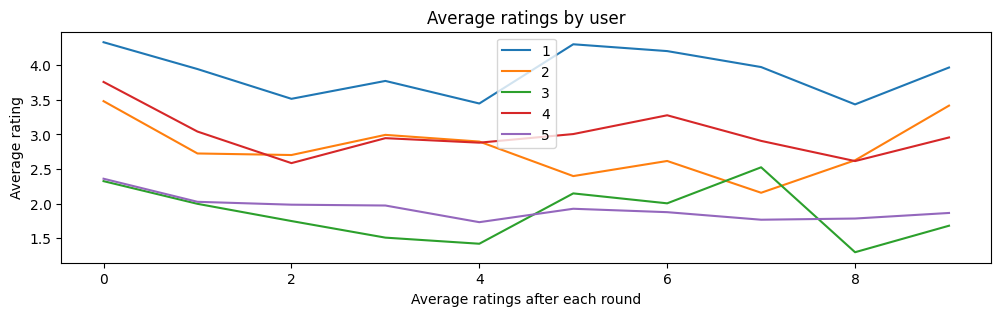

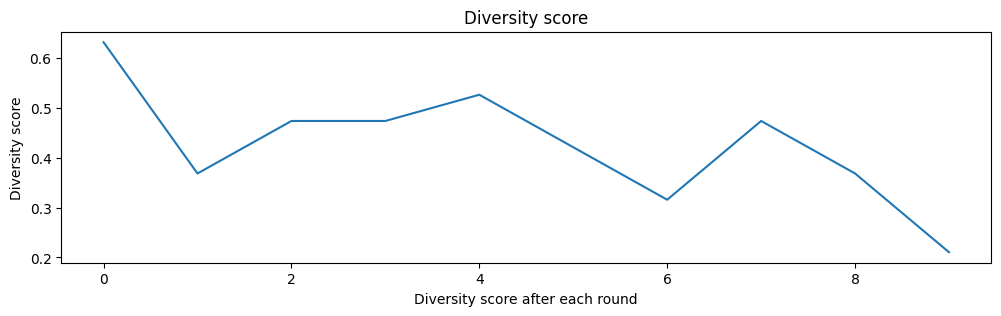

In [327]:
import matplotlib.pyplot as plt

# Plot the average ratings of the users
plt.figure(figsize=(12, 3))
plt.plot(average_ratings_by_user)
plt.xlabel("Average ratings after each round")
plt.ylabel("Average rating")
plt.title("Average ratings by user")
plt.legend(user_ids)
plt.show()

# Plot the diversity scores
plt.figure(figsize=(12, 3))
plt.plot(diversity_scores)
plt.xlabel("Diversity score after each round")
plt.ylabel("Diversity score")
plt.title("Diversity score")
plt.show()

In [328]:
# Average diversity score
average_diversity_score = np.mean(diversity_scores)
print(f"Average diversity score: {average_diversity_score:.2f}")

Average diversity score: 0.43


From the results we can see that our method works as intended. 5 predicted movies gave a diverse set of movies to watch. The diversity score of the recommended movies is 0.44 on average which is quite good. Pushing this score higher would have affected user ratings since it would have forced the model to recommend movie genres that are not liked by the users. Our results are for example missing genres of children and animation alltogether. This is due to the group of users not having a preference for these genres.

We notice that producing the diverse recommendations did not affect the fairness of the recommendations. The average ratings of the users stayed quite similar to the part 2 of the project.